In [2]:
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
from tqdm import tqdm_notebook

from scipy.misc import imread

%matplotlib inline

In [3]:
# Paths
DATA_FOLDER = 'E:/Data'


In [6]:
train_data = pd.read_csv(DATA_FOLDER + '/validation/train.csv')
labels = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

n_train = len(train_data)
n_labels = len(labels)
X_train = np.zeros((n_train, 3, 128, 128))
y_train = np.zeros((n_train, n_labels))
for i, (fname, label) in enumerate(tqdm_notebook(train_data.itertuples(index=False), total=n_train)):
    img = imread(DATA_FOLDER + '/train/{}/{}'.format(label, fname))
    img = cv2.resize(img, (128, 128)).transpose(2, 0, 1)
    X_train[i] = img
    y_train[i] = np_utils.to_categorical(labels.index(label), n_labels)
            
# Shuffle and prune
perm_idxs = np.random.permutation(n_train)
X_train = X_train[perm_idxs] / 255
y_train = y_train[perm_idxs]
        

In [8]:
val_data = pd.read_csv(DATA_FOLDER + '/validation/test.csv')

n_val = len(val_data)
X_val = np.zeros((n_val, 3, 128, 128))
y_val = np.zeros((n_val, n_labels))
for i, (fname, label) in enumerate(tqdm_notebook(val_data.itertuples(index=False), total=n_val)):
    img = imread(DATA_FOLDER + '/train/{}/{}'.format(label, fname))
    img = cv2.resize(img, (128, 128)).transpose(2, 0, 1)
    X_val[i] = img
    y_val[i] = np_utils.to_categorical(labels.index(label), n_labels)
            
# Shuffle and prune
perm_idxs = np.random.permutation(n_val)
X_val = X_val[perm_idxs] / 255
y_val = y_val[perm_idxs]

In [14]:
def keras_model_conv():
    model = Sequential()
    
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu', input_shape=(3, 128, 128)))
    model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy', 'categorical_crossentropy'])

    return model

model = keras_model_conv()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_21 (Convolution2D) (None, 16, 128, 128)  448         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 16, 128, 128)  2320        convolution2d_21[0][0]           
____________________________________________________________________________________________________
maxpooling2d_9 (MaxPooling2D)    (None, 16, 64, 64)    0           convolution2d_22[0][0]           
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 16, 64, 64)    0           maxpooling2d_9[0][0]             
___________________________________________________________________________________________

In [11]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=10,
                             zoom_range=[0.8, 1.2],
                             width_shift_range=0.1,
                             height_shift_range=0.1)
train_gen = datagen.flow(X_train, y_train)
val_gen = ImageDataGenerator().flow(X_val, y_val)

In [15]:
csv_logger = CSVLogger('full_run2_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.9)
checkpoint = ModelCheckpoint(filepath='E:/Models/full_image/model.{epoch:02d}-{loss}.hdf5', verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(X_train),
                    nb_epoch=500, verbose=2,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(X_val))

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/Joris/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64/tmpcrenxt/6c433366a2db29194908812c59be920d.lib and object C:/Users/Joris/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-2.7.12-64/tmpcrenxt/6c433366a2db29194908812c59be920d.exp



Epoch 1/500
Epoch 00000: val_loss improved from inf to 1.62224, saving model to E:/Models/full_image/model.00-1.65266820028.hdf5
22s - loss: 1.6527 - acc: 0.4631 - categorical_crossentropy: 1.6527 - val_loss: 1.6222 - val_acc: 0.4352 - val_categorical_crossentropy: 1.6222
Epoch 2/500
Epoch 00001: val_loss did not improve
21s - loss: 1.6193 - acc: 0.4518 - categorical_crossentropy: 1.6193 - val_loss: 1.6249 - val_acc: 0.4339 - val_categorical_crossentropy: 1.6249
Epoch 3/500
Epoch 00002: val_loss did not improve
21s - loss: 1.6157 - acc: 0.4717 - categorical_crossentropy: 1.6157 - val_loss: 1.6618 - val_acc: 0.4312 - val_categorical_crossentropy: 1.6618
Epoch 4/500
Epoch 00003: val_loss did not improve
20s - loss: 1.6158 - acc: 0.4588 - categorical_crossentropy: 1.6158 - val_loss: 1.6302 - val_acc: 0.4312 - val_categorical_crossentropy: 1.6302
Epoch 5/500

Epoch 00004: reducing learning rate to 0.000900000042748.
Epoch 00004: val_loss did not improve
20s - loss: 1.6158 - acc: 0.4624 - c

KeyboardInterrupt: 

In [16]:
def show_random(model):
    idx = np.random.randint(len(X_val))
    label = labels[np.flatnonzero(y_val[idx])[0]]
    plt.title(label)
    plt.imshow(X_val[idx].transpose(1, 2, 0))
    plt.show()
    print zip(model.predict_proba(X_val[idx].reshape(1, 3, 128, 128), verbose=0)[0], labels)

In [17]:
best_model = load_model('E:/Models/full_image/model.184-0.259635229905.hdf5')

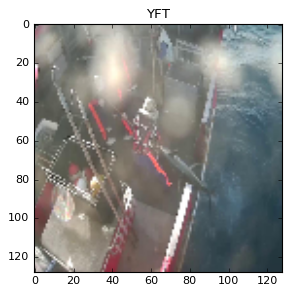

[(0.060797799, 'ALB'), (0.00055277097, 'BET'), (7.0152397e-05, 'DOL'), (2.2492952e-08, 'LAG'), (0.0023818649, 'NoF'), (0.0007628203, 'OTHER'), (5.3767476e-06, 'SHARK'), (0.93542916, 'YFT')]


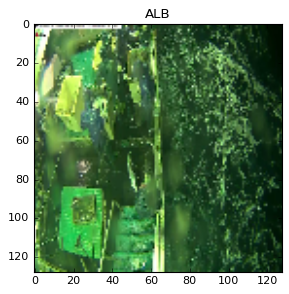

[(0.9999733, 'ALB'), (2.0965953e-07, 'BET'), (2.7122547e-14, 'DOL'), (8.7610744e-15, 'LAG'), (1.1799369e-05, 'NoF'), (7.7848902e-08, 'OTHER'), (1.5201841e-10, 'SHARK'), (1.4554277e-05, 'YFT')]


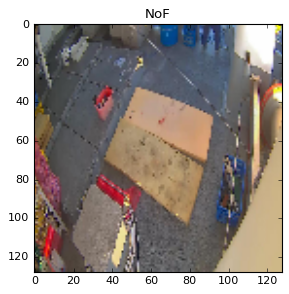

[(0.058757216, 'ALB'), (2.6336042e-05, 'BET'), (0.00033228946, 'DOL'), (4.9164978e-08, 'LAG'), (0.94069034, 'NoF'), (1.5928605e-05, 'OTHER'), (3.9118192e-12, 'SHARK'), (0.00017782026, 'YFT')]


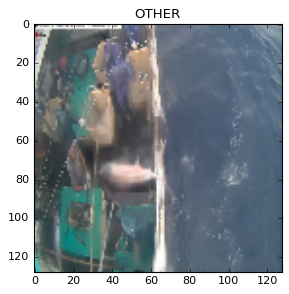

[(1.3864777e-05, 'ALB'), (2.9117533e-09, 'BET'), (1.6152335e-10, 'DOL'), (1.2742302e-11, 'LAG'), (1.2606331e-06, 'NoF'), (0.99998486, 'OTHER'), (1.1651789e-14, 'SHARK'), (1.766909e-10, 'YFT')]


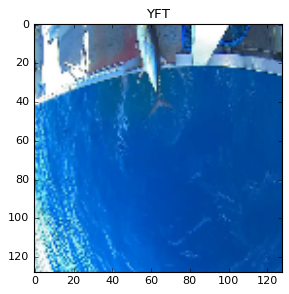

[(0.0027847718, 'ALB'), (0.00039158182, 'BET'), (0.00024827963, 'DOL'), (5.5258477e-07, 'LAG'), (0.89597195, 'NoF'), (4.8513348e-06, 'OTHER'), (3.1269962e-09, 'SHARK'), (0.10059791, 'YFT')]


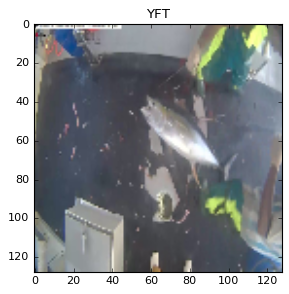

[(0.018627059, 'ALB'), (0.024803462, 'BET'), (8.4689435e-07, 'DOL'), (2.473184e-08, 'LAG'), (1.502784e-06, 'NoF'), (0.00015166475, 'OTHER'), (2.5117559e-09, 'SHARK'), (0.95641553, 'YFT')]


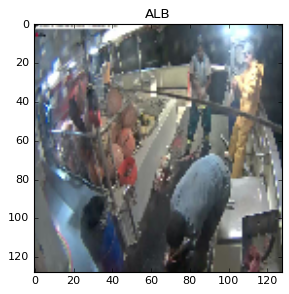

[(0.9998982, 'ALB'), (2.0831337e-06, 'BET'), (1.9193691e-10, 'DOL'), (2.6800248e-07, 'LAG'), (5.3958411e-05, 'NoF'), (1.6834159e-05, 'OTHER'), (5.137389e-14, 'SHARK'), (2.8591063e-05, 'YFT')]


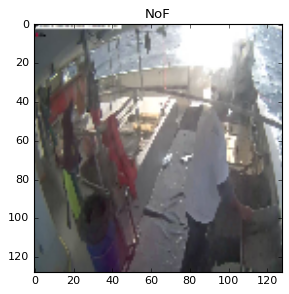

[(0.27352205, 'ALB'), (2.9591225e-05, 'BET'), (2.1060512e-08, 'DOL'), (2.3757016e-07, 'LAG'), (0.71789962, 'NoF'), (0.00013929857, 'OTHER'), (0.0059951958, 'SHARK'), (0.0024140151, 'YFT')]


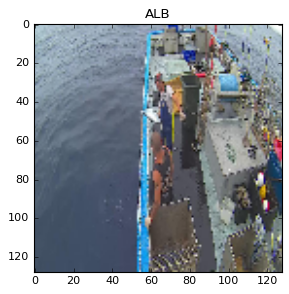

[(0.96439081, 'ALB'), (3.949703e-07, 'BET'), (2.672556e-09, 'DOL'), (1.8612671e-08, 'LAG'), (0.033574525, 'NoF'), (0.0019716329, 'OTHER'), (2.7066807e-09, 'SHARK'), (6.2617743e-05, 'YFT')]


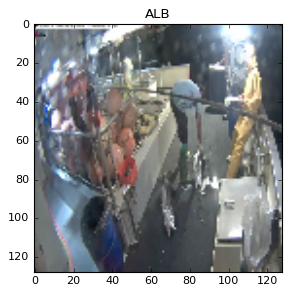

[(0.99981576, 'ALB'), (1.5690516e-06, 'BET'), (2.7777829e-11, 'DOL'), (2.7431469e-07, 'LAG'), (0.0001359845, 'NoF'), (1.8778597e-05, 'OTHER'), (2.8545051e-13, 'SHARK'), (2.7688622e-05, 'YFT')]


In [18]:
for _ in range(10):
    show_random(best_model)

In [22]:
test_files = glob.glob('E:/Data/test_stg1/*.jpg')
X_test = np.zeros((len(test_files), 3, 128, 128))
for i, f in enumerate(tqdm_notebook(test_files)):
    img = imread(f)
    img = cv2.resize(img, (128, 128)).transpose(2, 0, 1)
    X_test[i] = img
    
X_test = X_test / 255

In [34]:
import time

with open('subm.csv', 'w') as file:
    file.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for img, name in tqdm_notebook(zip(X_test, test_files)):
        probs = best_model.predict_proba(img.reshape(1, 3, 128, 128))[0]
        # Clip to avoid really high loss
        probs = np.clip(probs, 0.02, 0.98)
        file.write(os.path.basename(name) + ',' + ','.join([str(p) for p in probs])+'\n')
        # Sleep to avoind I/O error when writing too fast
        time.sleep(0.05)

1/1 [==============================] - 0s

